In [1]:
import pyedflib
import numpy as np

import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter
%matplotlib inline

In [1]:
hiddens = [10, 20, 30, 40, 50]
n_layers = [1, 2]
dropout = [0.1, 0.2]

params = [(h, l, dr) for h in hiddens for l in n_layers for dr in dropout]

In [2]:
params

[(10, 1, 0.1),
 (10, 1, 0.2),
 (10, 2, 0.1),
 (10, 2, 0.2),
 (20, 1, 0.1),
 (20, 1, 0.2),
 (20, 2, 0.1),
 (20, 2, 0.2),
 (30, 1, 0.1),
 (30, 1, 0.2),
 (30, 2, 0.1),
 (30, 2, 0.2),
 (40, 1, 0.1),
 (40, 1, 0.2),
 (40, 2, 0.1),
 (40, 2, 0.2),
 (50, 1, 0.1),
 (50, 1, 0.2),
 (50, 2, 0.1),
 (50, 2, 0.2)]

In [2]:
class CausalConv1d(nn.Conv1d):
    def __init__(self, *args, **kwargs):
        super(CausalConv1d, self).__init__(*args, **kwargs)
        self.padding = ((self.kernel_size[0] - 1) * self.dilation[0],)

    def forward(self, x):
        x = super(CausalConv1d, self).forward(x)
        return x[:, :, :-self.padding[0]]

    



class WaveNet(nn.Module):
    """WaveNet architecture with local conditioning

    https://arxiv.org/pdf/1609.03499.pdf - original paper
    https://arxiv.org/pdf/1702.07825.pdf - appending A for more details
    
    But given implementation has following differences:
    1. tanh is not applied to input embedding
    2. vector is scaled (multiplied 0.5 ** 0.5) between blocks
    3. GRU is used for processing mel spectrogram
    4. GRU output is nearest neighbour apsampled hop_size times
    5. each block has own conditioning projection

    Args:
        num_channels       (int): size of modelled categorical distribution
        residual_channels  (int): hidden vector size
        gate_channels      (int): gate block dimension
        skip_channels      (int): skip-vector size
        pre_channels       (int): dimension before the last layer
        dilation_cycles    (int): number of dilation cycles
        dilation_depth     (int): blocks number in dilation cycle (e.g. if set 10, max dilation = 2^(10-1))
        condition_channels (int): number of mel filters
        hop_size           (int): STFT hop size
    """

    def __init__(self,
                 num_channels,
                 residual_channels,
                 gate_channels,
                 skip_channels,
                 pre_channels,
                 dilation_cycles,
                 dilation_depth,
                 condition_channels,
                 hop_size):
        super(WaveNet, self).__init__()
        
        self.kernel_size = 2
        self.dilations = np.array([
            2 ** (i % dilation_depth) 
            for i in range(dilation_cycles * dilation_depth)
        ])
        
        self.num_channels = num_channels
        self.residual_channels = residual_channels
        self.gate_channels = gate_channels
        self.skip_channels = skip_channels
        self.pre_channels = pre_channels
        self.hop_size = hop_size
        
        
        self.conv_input = nn.Conv1d(
            in_channels=num_channels,
            out_channels=residual_channels,
            kernel_size=1)

        self.blocks_conv_filter = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])

        self.blocks_conv_gate = nn.ModuleList([
            CausalConv1d(
                in_channels=residual_channels,
                out_channels=gate_channels,
                kernel_size=2,
                dilation=d
            ) for d in self.dilations])
        
        self.blocks_conv_residual = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=residual_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations) - 1)])
        
        self.blocks_conv_skip = nn.ModuleList([
            nn.Conv1d(
                in_channels=gate_channels,
                out_channels=skip_channels,
                kernel_size=1
            ) for _ in range(len(self.dilations))])
        
        
        self.conv_out_1 = nn.Conv1d(
            in_channels=skip_channels,
            out_channels=pre_channels,
            kernel_size=1)
        self.conv_out_2 = nn.Conv1d(
            in_channels=pre_channels,
            out_channels=num_channels,
            kernel_size=1)
        
        self.lin1 = nn.Linear(num_channels, 1)
        
        self.lin2 = nn.Linear((2 ** dilation_depth) * dilation_cycles, 100)
                
        self.relu = nn.ReLU()
        self.lin3 = nn.Linear(100, 2)
        

    def forward(self, x):
        """
        Args:
            x (FloatTensor): continuous audio signal [B x K x T]

        Returns:
            FloatTensor: output [B x out_channels x T]
        """
        
        x = self.conv_input(x) # equal to x = torch.matmul(x.transpose(1, 2), model.conv_input.weight.squeeze().transpose(0, 1)) + model.conv_input.bias and transpose(1, 2)
        

        x_acc = 0
        for b in range(len(self.dilations)):
            x_filter = self.blocks_conv_filter[b](x)
            x_gate = self.blocks_conv_gate[b](x)


            x_hidden = torch.tanh(x_filter) * torch.sigmoid(x_gate)

            x_skip = self.blocks_conv_skip[b](x_hidden)
            x_acc = x_acc + x_skip

            if b < len(self.dilations) - 1:
                x_residual = self.blocks_conv_residual[b](x_hidden)
                x = x + x_residual

            x = x * 0.5 ** 0.5
            

        x = self.conv_out_1(torch.relu(x_acc))
        x = self.conv_out_2(torch.relu(x))
        
        x = x.transpose(1, 2)
        x = self.lin1(x)
        
        x = x[:, :, 0]
        
        x = self.relu(x)
        x = self.lin2(x)
        
        x = self.relu(x)
        x = self.lin3(x)
        
        
        
        return x

In [3]:
WaveNet_model = WaveNet(
    num_channels=23,
    residual_channels=32,
    gate_channels=32,
    skip_channels=64,
    pre_channels=128,
    dilation_cycles=9,
    dilation_depth=9,
    condition_channels=80,
    hop_size=300)
WaveNet_model.to("cuda")

WaveNet(
  (conv_input): Conv1d(23, 32, kernel_size=(1,), stride=(1,))
  (blocks_conv_filter): ModuleList(
    (0): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    (3): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
    (4): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(16,), dilation=(16,))
    (5): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(32,), dilation=(32,))
    (6): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(64,), dilation=(64,))
    (7): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(128,), dilation=(128,))
    (8): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(256,), dilation=(256,))
    (9): CausalConv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
    (10):

In [4]:
def run_epoch(model, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx in tqdm(range(100)):
        if is_training:
            optimizer.zero_grad()

        x = torch.rand(16, 23, 4608).to('cuda')
        
        
        y = torch.LongTensor([1]*16).view(-1).to('cuda')
        #y = y.view(-1)
        #print(y.size())

        out = model(x)

        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item())


    return epoch_loss

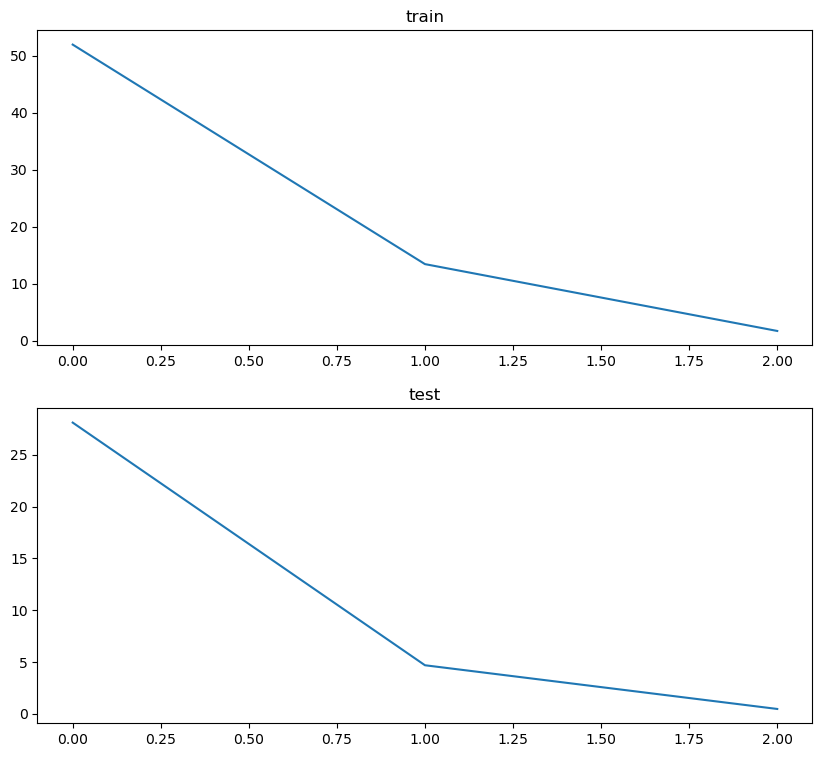

Epoch[3/1000] | loss train:1.694516, test:0.473343


 20%|████████████████▏                                                                | 20/100 [00:06<00:26,  3.04it/s]


KeyboardInterrupt: 

In [5]:
epochs = 1000
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(WaveNet_model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
lr = 0.001

losses_train = []
losses_test = []
best_loss = 10e9
# begin training
for epoch in range(epochs): 
    if epoch > 6:
        lr = 0.0005
    if epoch > 30:
        lr = 0.0001

    
    optimizer = optim.Adam(WaveNet_model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)    
    loss_train = run_epoch(WaveNet_model, is_training=True)
    loss_val = run_epoch(WaveNet_model)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        #torch.save(WaveNet_model.state_dict(), "./Draft")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, epochs, loss_train, loss_val))